In [1]:
import os
import random
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import json
from tqdm import tqdm

import os
import random
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, TimesformerForVideoClassification

In [2]:
def identify_device():
    # look for cuda
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    # look for MPS (Apple Silicon GPU)
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"Using 'Apple Silicion' GPU.")
    else:
        device = torch.device("cpu")
        print(f"No GPU availabe. Using CPU")
    return device

device = identify_device()

Using 'Apple Silicion' GPU.


In [13]:
class VideoDataset(Dataset):
    def __init__(self, annotation_file, root_dir, processor, num_frames=64, transform=None, subset="train"):
        self.annotation_file = annotation_file
        self.root_dir = root_dir
        self.processor = processor
        self.num_frames = num_frames
        self.transform = transform
        self.subset = subset

        # Load annotations
        with open(self.annotation_file, "r") as f:
            self.annotations = json.load(f)

        # Filter videos by subset
        self.video_list = [
            vid for vid, data in self.annotations.items() if data["subset"] == self.subset
        ]
        self.labels = {vid: data["action"][0] for vid, data in self.annotations.items()}

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_id = self.video_list[idx]
        label = self.labels[video_id]
        video_path = os.path.join(self.root_dir, f"{video_id}.mp4")

        # Load video frames
        frames = self.load_video_frames(video_path)

        # Apply transformations
        if self.transform:
            frames = self.apply_transforms(frames)

        # Process frames with processor
        inputs = self.processor(frames, return_tensors="pt")["pixel_values"]

        return inputs.squeeze(0), torch.tensor(label)

    def load_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        # Randomly select starting frame
        start_frame = random.randint(0, max(0, total_frames - self.num_frames))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # Resize logic
            h, w, c = frame.shape
            if min(w, h) < 226:
                scale = 226 / min(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)
            if max(w, h) > 256:
                scale = 256 / max(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append to frames list
            frames.append(frame)

        cap.release()

        # Pad frames if fewer than num_frames
        if len(frames) < self.num_frames:
            pad_frame = frames[0] if random.random() < 0.5 else frames[-1]
            if pad_frame is frames[0]:  # Prepend frames
                while len(frames) < self.num_frames:
                    frames.insert(0, pad_frame)
            else:  # Append frames
                while len(frames) < self.num_frames:
                    frames.append(pad_frame)

        return frames

    def apply_transforms(self, frames):
        """Apply transforms specific to the dataset subset."""
        if self.subset == "train" or self.subset == "val":
            pil_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
            ])
        else:  # For validation and testing
            pil_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
        return [pil_transforms(frame) for frame in frames]

Train Last Layer

In [ ]:
# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="test"
)

# Combine train and val datasets for training
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# DataLoaders
train_loader = DataLoader(combined_train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Training configuration
model.to(device)

print("Trainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.3)

best_val_accuracy = 0
epochs_no_improve = 0
epochs = 25

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs)
            predictions = outputs.logits.argmax(dim=-1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    val_accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)

        # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model_1_layer.pt")
        print("Validation accuracy improved, saving model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

In [14]:
# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="test"
)

# Combine train and val datasets for training
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# DataLoaders
train_loader = DataLoader(combined_train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


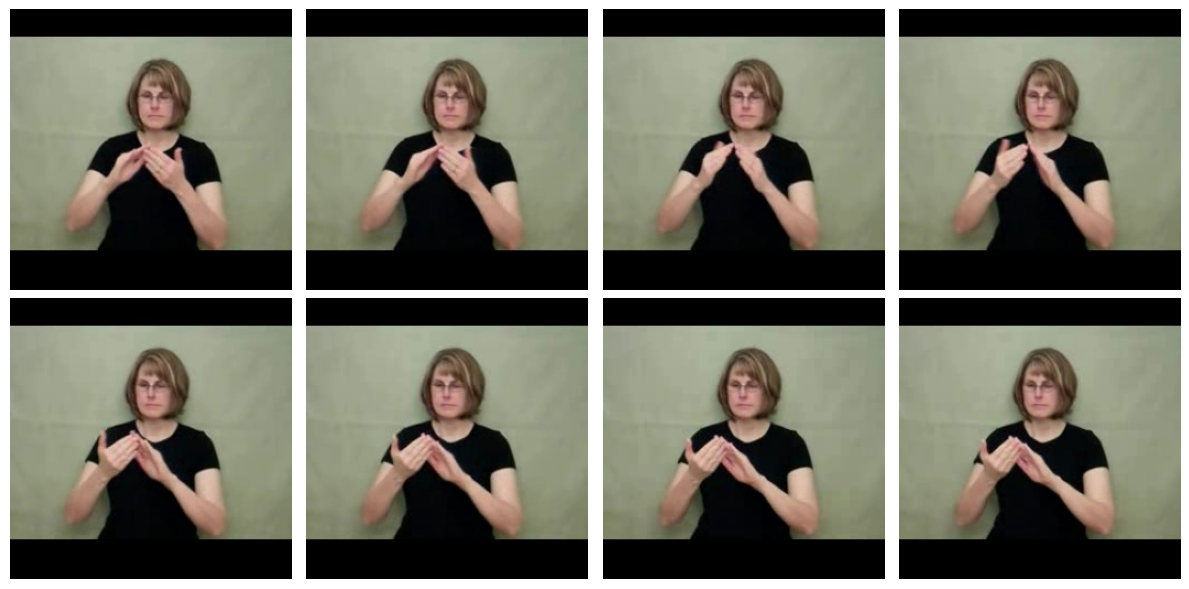

In [7]:
# Plot frames of a video in train_dataset
video_id = train_dataset.video_list[3]
video_path = os.path.join(root_dir, f"{video_id}.mp4")
frames = train_dataset.load_video_frames(video_path)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frames[i])
    ax.axis("off")
plt.tight_layout()
plt.show()

Train 2 Layers

In [ ]:
# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="test"
)

# Combine train and val datasets for training
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# DataLoaders
train_loader = DataLoader(combined_train_dataset, batch_size=6, shuffle=True, num_workers=12)
val_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=12)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for name, param in model.named_parameters():
    if "encoder.layer.11" in name or "classifier" in name:
        param.requires_grad = True

# Training configuration
model.to(device)

print("Trainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.3)

best_val_accuracy = 0
epochs_no_improve = 0
epochs = 25

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    # Use tqdm to create a progress bar for the training loop
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0
    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                predictions = outputs.logits.argmax(dim=-1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                pbar.update(1)

    val_accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model_2_Layers.pt")
        print("Validation accuracy improved, saving model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

Train 3 layers with ADAM

In [ ]:
# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    transform=None,  # No need to pass separate transforms; handled in apply_transforms
    subset="test"
)

# Combine train and val datasets for training
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# DataLoaders
train_loader = DataLoader(combined_train_dataset, batch_size=4, shuffle=True, num_workers=12)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=12)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for name, param in model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "classifier" in name:
        param.requires_grad = True

# Training configuration
model.to(device)

print("Trainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.3)

best_val_accuracy = 0
epochs_no_improve = 0
epochs = 25

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    # Use tqdm to create a progress bar for the training loop
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0
    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                predictions = outputs.logits.argmax(dim=-1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                pbar.update(1)

    val_accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_model_3_Layers.pt")
        print("Validation accuracy improved, saving model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

## Test models

In [ ]:
model.load_state_dict(torch.load("best_model_3_layers_Adam.pt", map_location=device)) # Load respective model
model.eval()

correct_top1 = 0
correct_top5 = 0
correct_top10 = 0
total = 0

with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.squeeze(1).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(pixel_values=videos)
        logits = outputs.logits
        _, top1_preds = logits.topk(1, dim=-1)  # Top-1 predictions
        _, top5_preds = logits.topk(5, dim=-1)  # Top-5 predictions
        _, top10_preds = logits.topk(10, dim=-1)  # Top-10 predictions

        # Update metrics
        correct_top1 += (top1_preds.squeeze() == labels).sum().item()
        correct_top5 += sum([labels[i] in top5_preds[i] for i in range(len(labels))])
        correct_top10 += sum([labels[i] in top10_preds[i] for i in range(len(labels))])
        total += labels.size(0)

# Calculate accuracies
top1_accuracy = correct_top1 / total
top5_accuracy = correct_top5 / total
top10_accuracy = correct_top10 / total

print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
print(f"Top-10 Accuracy: {top10_accuracy:.4f}")

In [ ]:
model.load_state_dict(torch.load("best_model_2_layers.pt", map_location=device)) # Load respective model
model.eval()

correct_top1 = 0
correct_top5 = 0
correct_top10 = 0
total = 0

with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.squeeze(1).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(pixel_values=videos)
        logits = outputs.logits
        _, top1_preds = logits.topk(1, dim=-1)  # Top-1 predictions
        _, top5_preds = logits.topk(5, dim=-1)  # Top-5 predictions
        _, top10_preds = logits.topk(10, dim=-1)  # Top-10 predictions

        # Update metrics
        correct_top1 += (top1_preds.squeeze() == labels).sum().item()
        correct_top5 += sum([labels[i] in top5_preds[i] for i in range(len(labels))])
        correct_top10 += sum([labels[i] in top10_preds[i] for i in range(len(labels))])
        total += labels.size(0)

# Calculate accuracies
top1_accuracy = correct_top1 / total
top5_accuracy = correct_top5 / total
top10_accuracy = correct_top10 / total

print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
print(f"Top-10 Accuracy: {top10_accuracy:.4f}")

Visualize Attention

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9q/cg6l7hvn3fb_mdts9xn_yg7h0000gn/T/ipykernel_4005/634187421.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

Frame shape before transpose: torch.Size([224, 224, 3])
Frame shape after transpose: (224, 224, 3)


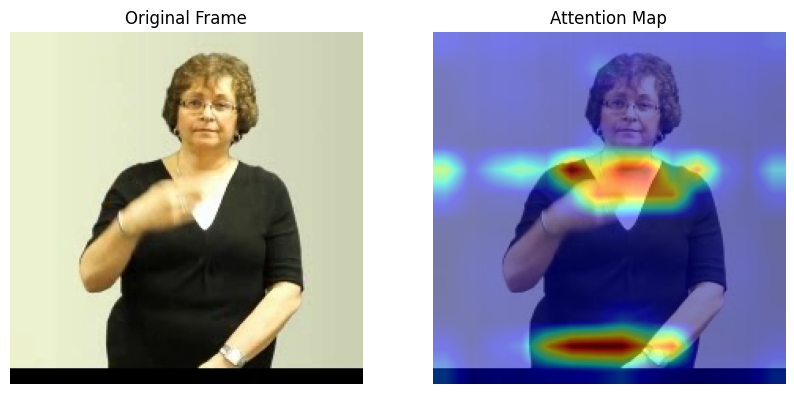

In [92]:
class VideoPreprocessor:
    def __init__(self, processor, num_frames=8):
        self.processor = processor
        self.num_frames = num_frames
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])

    def load_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Unable to open video file {video_path}")
            return []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        start_frame = random.randint(0, max(0, total_frames - self.num_frames))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            h, w, c = frame.shape
            if min(w, h) < 226:
                scale = 226 / min(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)
            if max(w, h) > 256:
                scale = 256 / max(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(self.transform(frame))

        cap.release()

        if len(frames) < self.num_frames:
            pad_frame = frames[0] if random.random() < 0.5 else frames[-1]
            while len(frames) < self.num_frames:
                frames.append(pad_frame)

        return torch.stack(frames)

pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights)
model = TimesformerForVideoClassification.from_pretrained(
    pretrained_weights, num_labels=100, ignore_mismatched_sizes=True, output_attentions=True
)

# Update the classifier to match the fine-tuned model's structure
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Ensure this matches the training structure
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

model.load_state_dict(torch.load("/Users/jakob/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Koeln/Semester 3/DeepLearning/I3d_Replication/best_model_3_Layers_fineTune (1).pt", map_location="cpu"))
model.eval()

preprocessor = VideoPreprocessor(processor=processor)
video_path = "/Users/jakob/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Koeln/Semester 3/DeepLearning/I3d_Replication/WLASL100_videos/06843.mp4"

video_frames = preprocessor.load_video_frames(video_path)

# Convert video frames to the required format for the processor
video_frames = video_frames.permute(0, 2, 3, 1)  # (T, C, H, W) -> (T, H, W, C)
video_frames = [frame.numpy() for frame in video_frames]  # Convert to a list of numpy arrays

# Process frames with the processor
inputs = processor(video_frames, return_tensors="pt")["pixel_values"]


with torch.no_grad():
    outputs = model(pixel_values=inputs)
    attentions = outputs.attentions

def visualize_attention(frame, attention_map, head=0, layer=-1, patch_size=16, frame_size=224):
    """
    Visualize a frame with its corresponding attention map.

    Args:
        frame (torch.Tensor): A single video frame, shape (C, H, W).
        attention_map (list): Model attention outputs.
        head (int): Attention head index.
        layer (int): Attention layer index.
        patch_size (int): Size of each patch (default: 16x16).
        frame_size (int): Size of the original frame (default: 224x224).
    """
    print(f"Frame shape before transpose: {frame.shape}")  # Debug shape

    # Convert frame to numpy array with HWC format for visualization
    if frame.shape[0] == 3:  # If in (C, H, W)
        frame = frame.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    elif frame.shape[-1] == 3:  # If already in (H, W, C)
        frame = frame.numpy()
    else:
        raise ValueError(f"Unexpected frame shape: {frame.shape}")

    print(f"Frame shape after transpose: {frame.shape}")  # Debug shape

    # Ensure the frame is in [0, 1] range for display
    frame = (frame - frame.min()) / (frame.max() - frame.min())

    # Extract attention map for the selected layer and head
    attention = attention_map[layer][0, head]  # Shape: [num_patches, num_patches]

    # Exclude the classification token
    attention = attention[1:, 1:]  # Remove the classification token
    num_patches = attention.size(0)

    # Compute the grid size for patches
    grid_height = frame_size // patch_size
    grid_width = frame_size // patch_size

    if grid_height * grid_width != num_patches:
        raise ValueError(f"Expected {grid_height * grid_width} patches but got {num_patches}.")

    # Reshape attention map to match the grid
    attention = attention.mean(dim=0).reshape(grid_height, grid_width).detach().numpy()

    # Resize and normalize the attention map
    attention = cv2.resize(attention, (frame_size, frame_size))  # Match original frame size
    attention = (attention - attention.min()) / (attention.max() - attention.min())

    # Plot original frame and attention overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Frame")
    plt.imshow(frame)  # Ensure frame shape is (H, W, C)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Attention Map")
    plt.imshow(frame)
    plt.imshow(attention, cmap="jet", alpha=0.5)  # Overlay attention
    plt.axis("off")
    plt.show()

# Visualize attention on the first frame
visualize_attention(torch.tensor(video_frames[3]), attentions)

## Test preprocessing

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import json
from tqdm import tqdm

class VideoDataset(Dataset):
    def __init__(self, annotation_file, root_dir, processor, num_frames=64, subset="train"):
        self.annotation_file = annotation_file
        self.root_dir = root_dir
        self.processor = processor
        self.num_frames = num_frames
        self.subset = subset

        # Load annotations
        with open(self.annotation_file, "r") as f:
            self.annotations = json.load(f)

        # Filter videos by subset
        self.video_list = [
            vid for vid, data in self.annotations.items() if data["subset"] == self.subset
        ]
        self.labels = {vid: data["action"][0] for vid, data in self.annotations.items()}

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_id = self.video_list[idx]
        label = self.labels[video_id]
        video_path = os.path.join(self.root_dir, f"{video_id}.mp4")

        # Load video frames
        frames = self.load_video_frames(video_path)

        # Apply transformations
        frames = self.apply_transforms(frames)

        # Process frames with processor
        inputs = self.processor(frames, return_tensors="pt")["pixel_values"]

        return inputs.squeeze(0), torch.tensor(label)

    def load_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
          print(f"Error: Unable to open video file {video_path}")
          return []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        # Randomly select starting frame
        start_frame = random.randint(0, max(0, total_frames - self.num_frames))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # Resize logic
            h, w, c = frame.shape
            if min(w, h) < 226:
                scale = 226 / min(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)
            if max(w, h) > 256:
                scale = 256 / max(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append to frames list
            frames.append(frame)

        cap.release()

        # Pad frames if fewer than num_frames
        if len(frames) < self.num_frames:
            pad_frame = frames[0] if random.random() < 0.5 else frames[-1]
            if pad_frame is frames[0]:  # Prepend frames
                while len(frames) < self.num_frames:
                    frames.insert(0, pad_frame)
            else:  # Append frames
                while len(frames) < self.num_frames:
                    frames.append(pad_frame)

        return frames

    def apply_transforms(self, frames):
        """Apply transforms specific to the dataset subset."""
        if self.subset == "train" or self.subset == "val":
            pil_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
            ])
        else:  # For validation and testing
            pil_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
        return [pil_transforms(frame) for frame in frames]

# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="test"
)

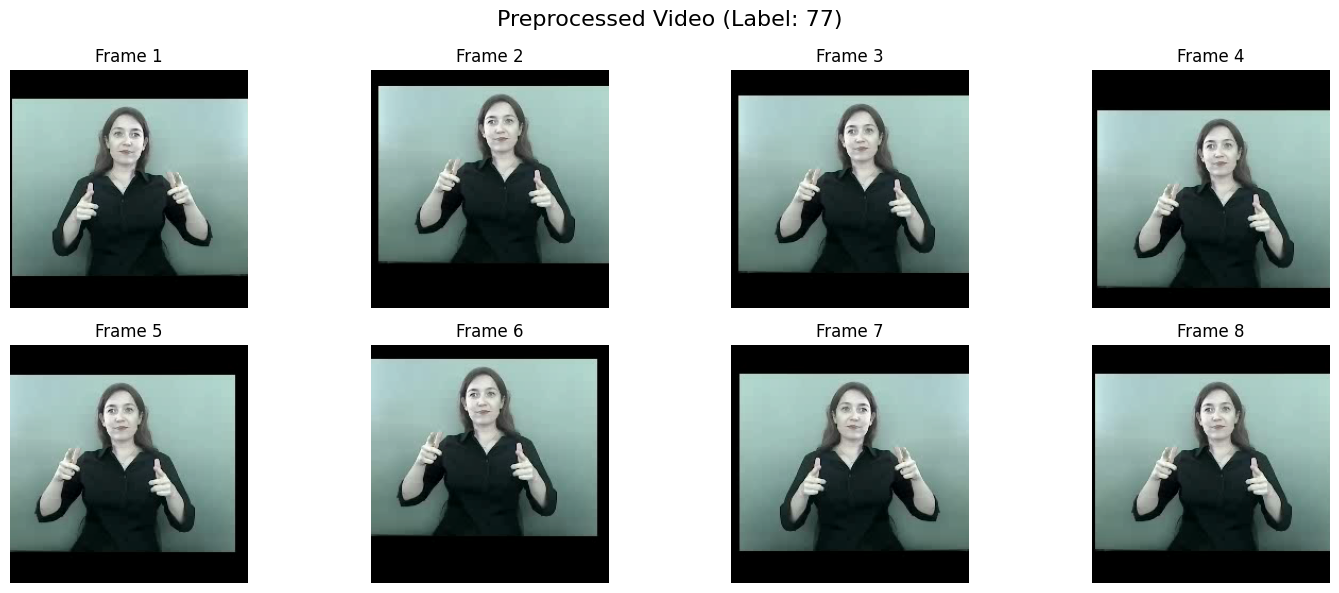

In [18]:
import matplotlib.pyplot as plt

def plot_preprocessed_video_from_dataset(dataset, index, num_frames=8, cols=4):
    """
    Visualize preprocessed video frames directly from the dataset.

    Args:
        dataset (Dataset): The VideoDataset object.
        index (int): The index of the video in the dataset to visualize.
        num_frames (int): Number of frames to display.
        cols (int): Number of columns in the grid.
    """
    # Retrieve preprocessed video and label from the dataset
    frames, label = dataset[index]  # frames: torch.Tensor, shape (T, C, H, W)

    # Select the first `num_frames` frames to display
    frames = frames[:num_frames]

    # Convert frames to numpy and ensure HWC format
    frames = [frame.permute(1, 2, 0).cpu().numpy() for frame in frames]  # (C, H, W) -> (H, W, C)

    # Normalize frames to [0, 1] for visualization
    frames = [(frame - frame.min()) / (frame.max() - frame.min()) for frame in frames]

    # Define rows based on the number of frames and columns
    rows = (num_frames + cols - 1) // cols

    # Create a figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < num_frames:
            axes[i].imshow(frames[i])
            axes[i].axis('off')
            axes[i].set_title(f"Frame {i + 1}")
        else:
            axes[i].axis('off')

    plt.suptitle(f"Preprocessed Video (Label: {label})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming `train_dataset` is already defined
plot_preprocessed_video_from_dataset(train_dataset, index=0, num_frames=8)

Preprocess video wise

In [43]:
import os
import random
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import json
from tqdm import tqdm

class VideoDataset(Dataset):
    def __init__(self, annotation_file, root_dir, processor, num_frames=64, subset="train"):
        self.annotation_file = annotation_file
        self.root_dir = root_dir
        self.processor = processor
        self.num_frames = num_frames
        self.subset = subset

        # Load annotations
        with open(self.annotation_file, "r") as f:
            self.annotations = json.load(f)

        # Filter videos by subset
        self.video_list = [
            vid for vid, data in self.annotations.items() if data["subset"] == self.subset
        ]
        self.labels = {vid: data["action"][0] for vid, data in self.annotations.items()}

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_id = self.video_list[idx]
        label = self.labels[video_id]
        video_path = os.path.join(self.root_dir, f"{video_id}.mp4")

        # Load video frames
        frames = self.load_video_frames(video_path)

        # Apply transformations
        frames = self.apply_transforms(frames)

        # Process frames with processor
        inputs = self.processor(frames, return_tensors="pt")["pixel_values"]

        return inputs.squeeze(0), torch.tensor(label)

    def load_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
          print(f"Error: Unable to open video file {video_path}")
          return []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        # Randomly select starting frame
        start_frame = random.randint(0, max(0, total_frames - self.num_frames))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # Resize logic
            h, w, c = frame.shape
            if min(w, h) < 226:
                scale = 226 / min(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)
            if max(w, h) > 256:
                scale = 256 / max(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append to frames list
            frames.append(frame)

        cap.release()

        # Pad frames if fewer than num_frames
        if len(frames) < self.num_frames:
            pad_frame = frames[0] if random.random() < 0.5 else frames[-1]
            if pad_frame is frames[0]:  # Prepend frames
                while len(frames) < self.num_frames:
                    frames.insert(0, pad_frame)
            else:  # Append frames
                while len(frames) < self.num_frames:
                    frames.append(pad_frame)

        return frames

    def apply_transforms(self, frames):
        """
        Apply consistent transforms to all frames in a video.
        """
        if self.subset == "train" or self.subset == "val":
            # Generate a single random crop and flip decision for the entire video
            crop_transform = transforms.RandomCrop(224)
            flip_transform = transforms.RandomHorizontalFlip(p=0.5)
            random_flip = random.random() < 0.5  # Determine if flipping is applied

            # Define a manual crop region using RandomCrop's get_params
            first_frame = transforms.ToPILImage()(frames[0])
            i, j, h, w = transforms.RandomCrop.get_params(first_frame, output_size=(224, 224))

            def consistent_transform(frame):
                frame = transforms.ToPILImage()(frame)
                frame = transforms.functional.crop(frame, i, j, h, w)  # Apply the same crop
                if random_flip:
                    frame = transforms.functional.hflip(frame)  # Apply the same flip
                return transforms.ToTensor()(frame)

            # Apply the consistent transforms to all frames
            return [consistent_transform(frame) for frame in frames]
        else:  # For validation and testing
            pil_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
            return [pil_transforms(frame) for frame in frames]

# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights, do_rescale=False)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="test"
)

# Combine train and val datasets for training
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# DataLoaders
train_loader = DataLoader(combined_train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for name, param in model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "classifier" in name:
        param.requires_grad = True

# Training configuration
model.to(device)

print("Trainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.3)

best_val_accuracy = 0
epochs_no_improve = 0
epochs = 200

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    # Use tqdm to create a progress bar for the training loop
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0
    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                predictions = outputs.logits.argmax(dim=-1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                pbar.update(1)

    val_accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model_3_Layers_correct_preproceesing.pt")
        print("Validation accuracy improved, saving model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters:
timesformer.encoder.layer.10.attention.attention.qkv.weight
timesformer.encoder.layer.10.attention.attention.qkv.bias
timesformer.encoder.layer.10.attention.output.dense.weight
timesformer.encoder.layer.10.attention.output.dense.bias
timesformer.encoder.layer.10.intermediate.dense.weight
timesformer.encoder.layer.10.intermediate.dense.bias
timesformer.encoder.layer.10.output.dense.weight
timesformer.encoder.layer.10.output.dense.bias
timesformer.encoder.layer.10.layernorm_before.weight
timesformer.encoder.layer.10.layernorm_before.bias
timesformer.encoder.layer.10.layernorm_after.weight
timesformer.encoder.layer.10.layernorm_after.bias
timesformer.encoder.layer.10.temporal_layernorm.weight
timesformer.encoder.layer.10.temporal_layernorm.bias
timesformer.encoder.layer.10.temporal_attention.attention.qkv.weight
timesformer.encoder.layer.10.temporal_attention.attention.qkv.bias
timesformer.encoder.layer.10.temporal_attention.output.dense.weight
timesformer.encoder.la

Training:   0%|          | 0/445 [00:06<?, ?batch/s]


KeyboardInterrupt: 

In [49]:
import os
import random
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import json
from tqdm import tqdm

class VideoDataset(Dataset):
    def __init__(self, annotation_file, root_dir, processor, num_frames=64, subset="train"):
        self.annotation_file = annotation_file
        self.root_dir = root_dir
        self.processor = processor
        self.num_frames = num_frames
        self.subset = subset

        # Load annotations
        with open(self.annotation_file, "r") as f:
            self.annotations = json.load(f)

        # Filter videos by subset
        self.video_list = [
            vid for vid, data in self.annotations.items() if data["subset"] == self.subset
        ]
        self.labels = {vid: data["action"][0] for vid, data in self.annotations.items()}

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_id = self.video_list[idx]
        label = self.labels[video_id]
        video_path = os.path.join(self.root_dir, f"{video_id}.mp4")

        # Load video frames
        frames = self.load_video_frames(video_path)

        # Apply transformations
        frames = self.apply_transforms(frames)

        # Process frames with processor
        inputs = self.processor(frames, return_tensors="pt")["pixel_values"]

        return inputs.squeeze(0), torch.tensor(label)

    def load_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
          print(f"Error: Unable to open video file {video_path}")
          return []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        # Randomly select starting frame
        start_frame = random.randint(0, max(0, total_frames - self.num_frames))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # Resize logic
            h, w, c = frame.shape
            if min(w, h) < 226:
                scale = 226 / min(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)
            if max(w, h) > 256:
                scale = 256 / max(w, h)
                frame = cv2.resize(frame, dsize=(0, 0), fx=scale, fy=scale)

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append to frames list
            frames.append(frame)

        cap.release()

        # Pad frames if fewer than num_frames
        if len(frames) < self.num_frames:
            pad_frame = frames[0] if random.random() < 0.5 else frames[-1]
            if pad_frame is frames[0]:  # Prepend frames
                while len(frames) < self.num_frames:
                    frames.insert(0, pad_frame)
            else:  # Append frames
                while len(frames) < self.num_frames:
                    frames.append(pad_frame)

        return frames

    def apply_transforms(self, frames):
        """
        Apply consistent transforms to all frames in a video.
        """
        if self.subset == "train" or self.subset == "val":
            # Generate a single random crop and flip decision for the entire video
            crop_transform = transforms.RandomCrop(224)
            flip_transform = transforms.RandomHorizontalFlip(p=0.5)
            random_flip = random.random() < 0.5  # Determine if flipping is applied

            # Define a manual crop region using RandomCrop's get_params
            first_frame = transforms.ToPILImage()(frames[0])
            i, j, h, w = transforms.RandomCrop.get_params(first_frame, output_size=(224, 224))

            def consistent_transform(frame):
                frame = transforms.ToPILImage()(frame)
                frame = transforms.functional.crop(frame, i, j, h, w)  # Apply the same crop
                if random_flip:
                    frame = transforms.functional.hflip(frame)  # Apply the same flip
                return transforms.ToTensor()(frame)

            # Apply the consistent transforms to all frames
            return [consistent_transform(frame) for frame in frames]
        else:  # For validation and testing
            pil_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
            return [pil_transforms(frame) for frame in frames]

# Configuration
annotation_file = 'nslt_100.json'
root_dir = 'WLASL100_videos'
pretrained_weights = "facebook/timesformer-base-finetuned-k400"
processor = AutoImageProcessor.from_pretrained(pretrained_weights, do_rescale=False)
model = TimesformerForVideoClassification.from_pretrained(pretrained_weights, num_labels=100, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Apply 50% dropout
    nn.Linear(model.classifier.in_features, model.classifier.out_features)
)

# Training Dataset (random cropping and flipping)
train_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="train"
)

# Validation Dataset (center cropping)
val_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="val"
)

# Testing Dataset (center cropping)
test_dataset = VideoDataset(
    annotation_file=annotation_file,
    root_dir=root_dir,
    processor=processor,
    num_frames=64,
    subset="test"
)

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


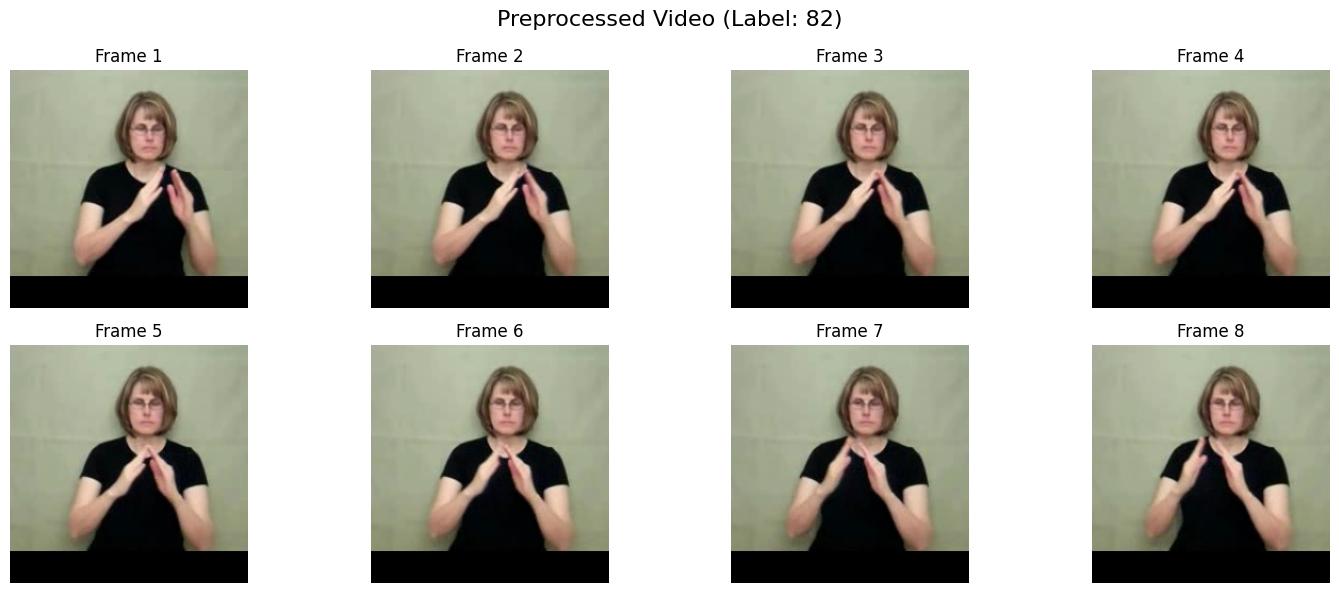

In [50]:
import matplotlib.pyplot as plt

def plot_preprocessed_video_from_dataset(dataset, index, num_frames=8, cols=4):
    """
    Visualize preprocessed video frames directly from the dataset.

    Args:
        dataset (Dataset): The VideoDataset object.
        index (int): The index of the video in the dataset to visualize.
        num_frames (int): Number of frames to display.
        cols (int): Number of columns in the grid.
    """
    # Retrieve preprocessed video and label from the dataset
    frames, label = dataset[index]  # frames: torch.Tensor, shape (T, C, H, W)

    # Select the first `num_frames` frames to display
    frames = frames[:num_frames]

    # Convert frames to numpy and ensure HWC format
    frames = [frame.permute(1, 2, 0).cpu().numpy() for frame in frames]  # (C, H, W) -> (H, W, C)

    # Normalize frames to [0, 1] for visualization
    frames = [(frame - frame.min()) / (frame.max() - frame.min()) for frame in frames]

    # Define rows based on the number of frames and columns
    rows = (num_frames + cols - 1) // cols

    # Create a figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < num_frames:
            axes[i].imshow(frames[i])
            axes[i].axis('off')
            axes[i].set_title(f"Frame {i + 1}")
        else:
            axes[i].axis('off')

    plt.suptitle(f"Preprocessed Video (Label: {label})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming `train_dataset` is already defined
plot_preprocessed_video_from_dataset(train_dataset, index=3, num_frames=8)